# Decision Trees for Malware Detection

## 1. Introduction

### What is a Decision Tree?


A **decision tree** is a supervised machine learning algorithm used for both **classification** and **regression** tasks. The idea is to partition the data into subsets by making decisions based on feature values. Each internal node of the tree corresponds to a decision on a feature, and each leaf node corresponds to a predicted class (for classification) or a value (for regression).

**Why use a Decision Tree?**

- **Interpretability**: It provides a visual and easy-to-understand representation of the decision-making process.
- **Feature Importance**: It helps identify which features are more important in predicting the target variable.
- **Non-parametric**: Unlike many other machine learning algorithms, decision trees don't assume any underlying data distribution.

In this notebook, we will use a decision tree to classify whether a given file is malicious based on the features provided in the dataset.
<center>
  <img src="https://www.researchgate.net/publication/276126027/figure/fig1/AS:639215637381121@1529412292299/An-example-of-Decision-Tree-with-4-nodes-3-features-and-3-classes-The-colored-dotted.png" alt="Image Description" />
</center>


## 2. How a Decision Tree Works


A decision tree algorithm works by recursively partitioning the dataset into two or more homogeneous sets. The goal is to find the best possible split at each node of the tree to separate the classes as much as possible.

### 2.1 Gini Impurity

One of the common ways to evaluate the quality of a split is by calculating the **Gini impurity**. Gini impurity measures how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.

Mathematically, Gini impurity for a set $ S $ is calculated as:

$
G(S) = 1 - \sum_{i=1}^{C} p_i^2
$

where $ C $ is the number of classes, and $ p_i $ is the proportion of class $ i $ in the set $ S $.

**If all elements belong to a single class, Gini impurity is 0 (pure). The closer the value is to 1, the less pure the set.**
<center>
  <img src="https://miro.medium.com/v2/resize:fit:1128/1*TjcEyYWh51cBaAo5M0fkEQ.png" alt="Image Description" />
</center>

#### Example: Gini Impurity with Balls in a Container

Let's illustrate Gini impurity with a simple example. Imagine a container filled with different colored balls. The colors represent the different classes.

- **Scenario 1**: The container has 100 balls, all of which are red (belonging to the same class). 
  - Gini impurity here would be 0 because there is no uncertainty about the class of any randomly selected ball.

- **Scenario 2**: The container has 10 red balls and 90 blue balls (two classes). 
  - Gini impurity would be higher in this case, as there is a 50% chance of drawing a red ball and a 50% chance of drawing a blue ball, which increases the uncertainty.

Let’s calculate the Gini impurity for these two scenarios:

1. **Scenario 1 (All Red Balls)**:  
   Since there is only one class (red), $ p_{red} = 1 $ and $ p_{blue} = 0 $.

   $
   G = 1 - (1^2) = 0
   $

2. **Scenario 2 (5 Red Balls, 5 Blue Balls)**:  
   Here, $ p_{red} = 0.5 $ and $ p_{blue} = 0.5 $.

   $
   G = 1 - (0.1^2 + 0.9^2) = 1 - 0.5 = 0.18
   $

In this example, the Gini impurity in the second scenario is higher than in the first because there is more diversity in the classes.
<center>
  <img src="data/containers.webp" alt="Image Description" , width = "400"/>
</center>
Now, let’s implement this concept in our decision tree.


In [27]:
! pip install networkx --quiet 



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [28]:
# Step 1: Load the dataset

import pandas as pd
import numpy as np
import os

# Load the dataset from a CSV file
path = os.path.join("data", "malware_detection_dataset.csv")
df = pd.read_csv(path, index_col=False)

# Display the first few rows of the dataset
df.head()


,Unnamed: 0,packets,data_size,duration,protocol_type,src_ip_entropy,dst_ip_entropy,src_port,dst_port,is_malicious
0,0,549,23925,46.636386,0,0.562393,0.542418,25035,33550,0
1,1,486,11111,46.837479,2,0.409978,0.580064,62894,19715,0
2,2,564,23573,83.531412,1,0.448570,0.471148,42483,50710,0
3,3,652,18831,62.139664,0,0.554119,0.514444,13085,15047,0
4,4,476,23537,87.209764,1,0.475231,0.553307,56395,42063,0


### Step 2: Gini Impurity Calculation

The Gini impurity is used to evaluate the quality of a split at each node. Let's implement the function to calculate the Gini impurity.


In [29]:
# Gini impurity function
def gini_impurity(classes):
    total = np.sum(classes)
    if total == 0:
        return 0  # If no samples, return 0 impurity
    probs = np.array(classes) / total
    return 1 - np.sum(probs ** 2)

# Example calculation
example_classes = [40, 60]  # 40 samples of class 0, 60 samples of class 1
print(f"Gini Impurity for example split: {gini_impurity(example_classes):.4f}")


Gini Impurity for example split: 0.4800


### Step 3: Splitting Data

At each node, we need to split the dataset based on a chosen feature and threshold. Below is the function that splits the dataset into two parts based on the feature and threshold.


In [30]:
# Function to split the dataset based on a feature and value
def split_data(data, feature, value):
    data = np.array(data)
    left = data[data[:, feature] <= value]
    right = data[data[:, feature] > value]
    return left.tolist(), right.tolist()

# Example of splitting the dataset
example_data = [[2, 1], [3, 0], [4, 1], [5, 0], [6, 1]]
left, right = split_data(example_data, 0, 4)
print(f"Left split: {left}")
print(f"Right split: {right}")


Left split: [[2, 1], [3, 0], [4, 1]]
Right split: [[5, 0], [6, 1]]


### Step 4: Calculating Gini Impurity for a Split

To evaluate the quality of a split, we need to compute the Gini impurity of both the left and right subsets and then take the weighted average.


In [31]:
# Function to calculate Gini for a split
def calculate_split_gini(left, right):
    n = len(left) + len(right)
    if n == 0:
        return 0  # Avoid division by zero
    
    if len(left) == 0:
        gini_left = 0
    else:
        gini_left = gini_impurity([row[-1] for row in left])
    
    if len(right) == 0:
        gini_right = 0
    else:
        gini_right = gini_impurity([row[-1] for row in right])
    
    # Weighted average of Gini impurities
    return (len(left) / n) * gini_left + (len(right) / n) * gini_right
data = [
    [2.3, 1],  # Feature value, Label
    [1.8, 0],
    [3.1, 1],
    [2.5, 0],
    [3.7, 1],
    [1.6, 0]
]
left, right = split_data(data, feature=0, value=2.5)
gini = calculate_split_gini(left, right)
print(f"Gini Impurity of the split: {gini:.4f}")


Gini Impurity of the split: 0.1667


### Step 5: Finding the Best Split

To build the decision tree, we need to find the best feature and threshold at each node that minimizes the Gini impurity.


In [32]:
import random

# Function to find the best split
def find_best_split(data, n_samples=20):
    best_gini = float('inf')
    best_split = None
    n_features = len(data[0]) - 1  # Assuming the last column is the label
    
    for feature in range(n_features):
        feature_values = [row[feature] for row in data]
        
        # Randomly sample `n_samples` values from the feature's unique values
        values = random.sample(list(set(feature_values)), min(len(set(feature_values)), n_samples))
        
        for value in values:
            left, right = split_data(data, feature, value)
            gini = calculate_split_gini(left, right)
            
            if gini < best_gini:
                best_gini = gini
                best_split = (feature, value)
    
    return best_split


### Step 6: Building the Tree

We can now build the tree recursively. At each node, the function will find the best split, and then recursively build the left and right subtrees.


In [33]:
# Function to check if a node is pure (all samples have the same class)
def is_pure(data):
    classes = [row[-1] for row in data]
    return len(set(classes)) == 1

# Function to create a leaf node (return the majority class)
def leaf_node(data):
    classes = [row[-1] for row in data]
    return max(set(classes), key=classes.count)

# Recursive function to build the decision tree
def build_tree(data, max_depth, min_samples_split=2, depth=0):
    # Stop if max depth is reached, the node is pure, or there's not enough data to split
    if depth == max_depth or is_pure(data) or len(data) < min_samples_split:
        return leaf_node(data)
    
    # Find the best split
    feature, value = find_best_split(data)
    
    # Split the data
    left, right = split_data(data, feature, value)
    
    # Recursively build the left and right subtrees
    return {
        'feature': feature,
        'value': value,
        'left': build_tree(left, max_depth, min_samples_split, depth + 1),
        'right': build_tree(right, max_depth, min_samples_split, depth + 1)
    }


### Step 7: Making Predictions

Once the tree is built, we can use it to make predictions by traversing the tree from the root to the leaf nodes based on the values of the features.


In [34]:
# Function to predict for a single sample
def predict_one(tree, sample):
    if isinstance(tree, dict):
        feature = tree['feature']
        value = tree['value']
        if sample[feature] <= value:
            return predict_one(tree['left'], sample)
        else:
            return predict_one(tree['right'], sample)
    else:
        return tree

# Function to predict for the entire dataset
def predict(tree, data):
    return [predict_one(tree, sample) for sample in data]


### Step 8: Building and Evaluating the Model

Now, we will prepare the dataset, build the decision tree, and evaluate its accuracy.


In [35]:
# Prepare the dataset by separating features and target labels
X = df.drop(columns=['is_malicious', 'Unnamed: 0'])
y = df['is_malicious']

# Convert the dataframe into a list of lists for manual implementation
data = X.values.tolist()
labels = y.values.tolist()

# Append the labels to the data
for i in range(len(data)):
    data[i].append(labels[i])

# Build the decision tree using a maximum depth of n<10 for simplicity
tree = build_tree(data, max_depth=2)

# Make predictions using the built tree on the original dataset
predictions = predict(tree, X.values.tolist())

# Evaluate the accuracy of our model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, predictions)

# Output the accuracy of the model
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 99.84%


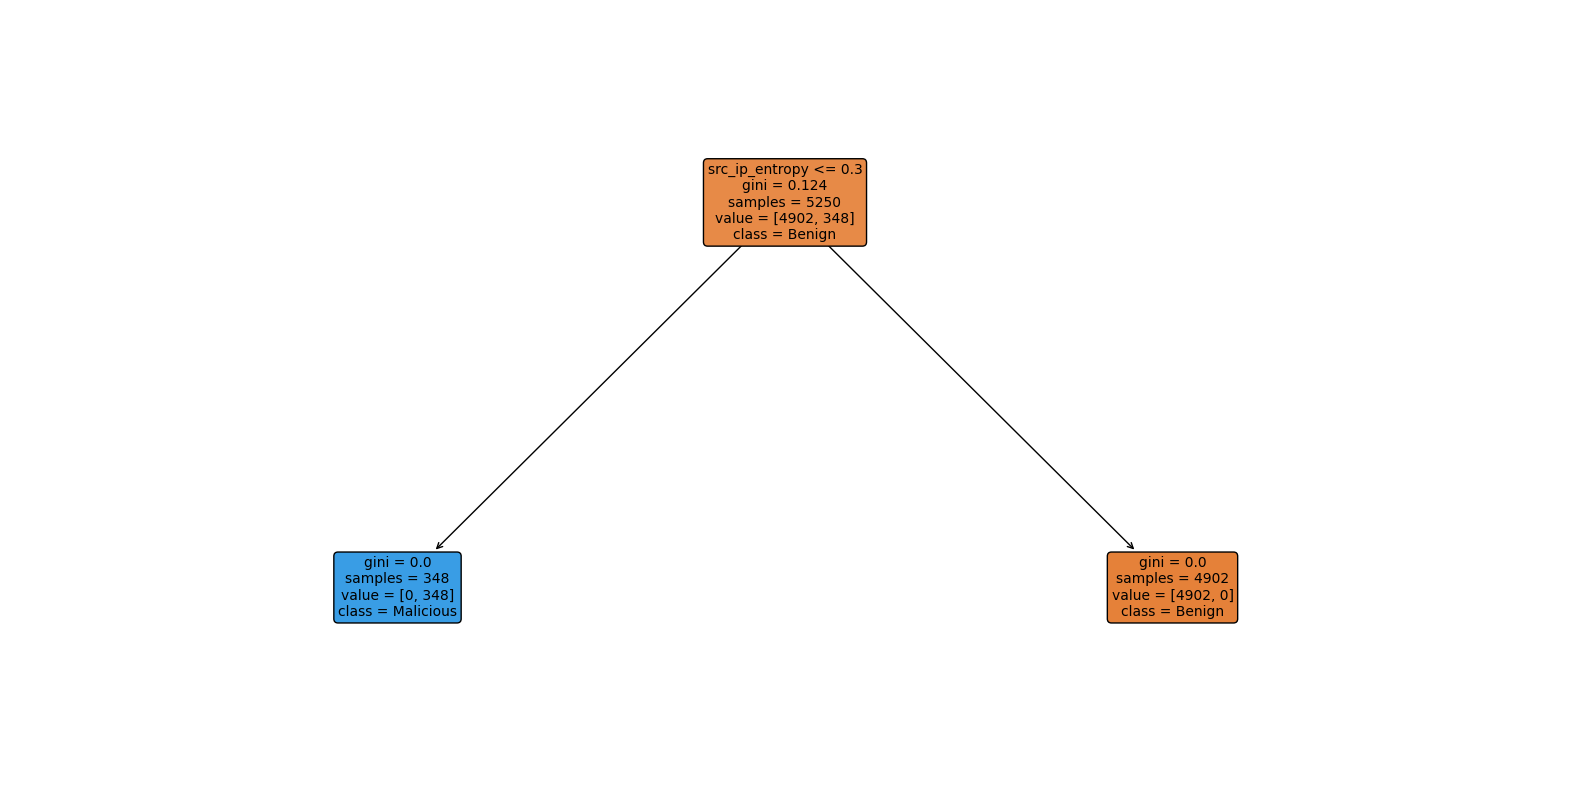

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

# Prepare the dataset by separating features and the target
X = df.drop(columns=['Unnamed: 0', 'is_malicious'])
y = df['is_malicious']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the decision tree classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=X.columns, class_names=["Benign", "Malicious"], filled=True, rounded=True, fontsize=10)
plt.show()
